# Planar III-V on planar Si, with rear grating

In this example, we will build two structures similar to those described in [this
paper](https://doi.org/10.1038/s41560-018-0125-0). These are both triple-junction,
two-terminal GaInP/GaAs/Si cells; one cell is planar, while the other has a
diffraction grating deposited on the rear of the bottom Si cell to boost its current.

## Setting up

In [18]:
from solcore import material, si
from solcore.absorption_calculator import search_db, download_db
import os
from solcore.structure import Layer
from solcore.light_source import LightSource
from rayflare.transfer_matrix_method import tmm_structure
from rayflare.options import default_options
from rayflare.structure import Interface, BulkLayer, Structure
from rayflare.matrix_formalism import process_structure, calculate_RAT
from solcore.constants import q
import numpy as np
import matplotlib.pyplot as plt

As before, we load some materials from the refractiveindex.info database. The MgF$_2$
 and Ta$_2$O$_5$ are the same as the [ARC example](6-arc_optimization.ipynb); the SU8
  is a negative photoresist which was used in the reference paper The optical
  constants for silver are also loaded from a reliable literature source. Note that
  the exact compositions of some semiconductor alloy layers (InGaP, AlInP and AlGaAs)
   are not given in the paper and are thus reasonable guesses.

In [19]:
# download_db(confirm=True) # only needs to be run once
# commented out because this should have already been done in a previous example. Uncomment if necessary.

In [20]:
%%capture

MgF2_pageid = search_db(os.path.join("MgF2", "Rodriguez-de Marcos"))[0][0];
Ta2O5_pageid = search_db(os.path.join("Ta2O5", "Rodriguez-de Marcos"))[0][0];
SU8_pageid = search_db("SU8")[0][0];
Ag_pageid = search_db(os.path.join("Ag", "Jiang"))[0][0];

MgF2 = material(str(MgF2_pageid), nk_db=True)();
Ta2O5 = material(str(Ta2O5_pageid), nk_db=True)();
SU8 = material(str(SU8_pageid), nk_db=True)();
Ag = material(str(Ag_pageid), nk_db=True)();

window = material("AlInP")(Al=0.52)
GaInP = material("GaInP")(In=0.5)
AlGaAs = material("AlGaAs")(Al=0.8)
GaAs = material("GaAs")()
Si = material("Si")()

Air = material("Air")()
Al2O3 = material("Al2O3P")()
Al = material("Al")()

## Defining the cell layers

Now we define the layers for the III-V top junctions, and the Si wafer, grouping them
together in a logical way. In this example, we will only do optical simulations, so
we will not set e.g. diffusion lengths or doping levels.

In [21]:
ARC = [Layer(110e-9, MgF2), Layer(65e-9, Ta2O5)]

GaInP_junction = [Layer(17e-9, window), Layer(400e-9, GaInP), Layer(100e-9, AlGaAs)]

tunnel_1 = [Layer(80e-9, AlGaAs), Layer(20e-9, GaInP)]

GaAs_junction = [Layer(17e-9, GaInP), Layer(1050e-9, GaAs), Layer(70e-9, AlGaAs)]

tunnel_2 = [Layer(50e-9, AlGaAs), Layer(125e-9, GaAs)]

Si_junction = [Layer(280e-6, Si)]

coh_layers = len(ARC) + len(GaInP_junction) + len(tunnel_1) + len(GaAs_junction) + len(tunnel_2)

As for [the InGaP//Si example](8-InGaP_Si_planar.ipynb), to get physically reasonable results we
must treat the very thick layers in the structure incoherently. The `coh_layers`
variable sums up how many thin layers (which must be treated coherently) must be
included in the `coherency_list` options.

## Planar cell

Now we define the planar cell, and options for the solver:

In [22]:
cell_planar = tmm_structure(
    ARC + GaInP_junction + tunnel_1 + GaAs_junction + tunnel_2 + Si_junction,
    incidence=Air, transmission=Ag,
)

n_layers = cell_planar.layer_stack.num_layers

coherency_list = ["c"]*coh_layers + ["i"] # Si to be treated incoherently

options = default_options()

wl = np.arange(300, 1201, 10) * 1e-9
AM15G = LightSource(source_type="standard", version="AM1.5g", x=wl,
                    output_units="photon_flux_per_m")

options.wavelength = wl
options.coherency_list = coherency_list
options.coherent = False

Run the TMM calculation for the planar cell, and then extract the relevant layer
absorptions. These are used to calculate limiting currents (100% internal quantum
efficiency), which are displayed on the plot with the absorption in each layer.

Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ag/Jiang.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/MgF2/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.
Database file found at /Users/z3533914/.solcore/nk/nk.db
Material main/Ta2O5/Rodriguez-de Marcos.yml loaded.


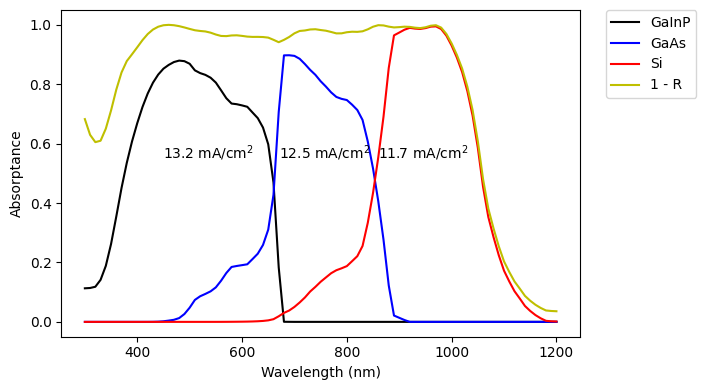

In [23]:
tmm_result = cell_planar.calculate(options=options)

GaInP_A = tmm_result['A_per_layer'][:,3]
GaAs_A = tmm_result['A_per_layer'][:,8]
Si_A = tmm_result['A_per_layer'][:,coh_layers]

Jmax_GaInP = q*np.trapz(GaInP_A*AM15G.spectrum()[1], x=wl)/10
Jmax_GaAs = q*np.trapz(GaAs_A*AM15G.spectrum()[1], x=wl)/10
Jmax_Si = q*np.trapz(Si_A*AM15G.spectrum()[1], x=wl)/10

R_spacer_ARC = tmm_result['R']

plt.figure(figsize=(6,4))
plt.plot(wl * 1e9, GaInP_A, "-k", label="GaInP")
plt.plot(wl * 1e9, GaAs_A, "-b", label="GaAs")
plt.plot(wl * 1e9, Si_A, "-r", label="Si")
plt.plot(wl * 1e9, 1 - R_spacer_ARC, '-y', label="1 - R")

plt.text(450, 0.55, r"{:.1f} mA/cm$^2$".format(Jmax_GaInP))
plt.text(670, 0.55, r"{:.1f} mA/cm$^2$".format(Jmax_GaAs))
plt.text(860, 0.55, r"{:.1f} mA/cm$^2$".format(Jmax_Si))
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorptance")
plt.tight_layout()
plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Cell with rear grating

Now, for the cell with a grating on the rear, we have a multi-scale problem where we
must combine the calculation of absorption in a very thick (compared to the
wavelengths of light) layer of Si with the effect of a wavelength-scale (1000 nm
pitch) diffraction grating. For this, we will use the Angular Redistribution Matrix
Method (ARMM) which was also used in [the textured Si example](9-grating_pyramids_OPTOS.ipynb).

The front surface of the cell (i.e. all the layers on top of Si) are planar, and can
be treated using TMM. The rear surface of the cell, which has a crossed grating
consisting of silver and SU8, must be treated with RCWA to account for diffraction.
The thick Si layer will be the bulk coupling layer between these two interfaces.

First, we set up the rear grating surface; we must define its lattice vectors, and
place the Ag rectangle in the unit cell of the grating. More details on how unit cells
 of different shapes can be defined for the RCWA solver can be found
 [here](https://rayflare.readthedocs.io/en/latest/Examples/rcwa_examples.html).

In [24]:
x = 1000

d_vectors = ((x, 0), (0, x))
area_fill_factor = 0.4
hw = np.sqrt(area_fill_factor) * 500

back_materials = [
        Layer(width=si("250nm"), material=SU8,
        geometry=[{"type": "rectangle", "mat": Ag, "center": (x / 2, x / 2),
                   "halfwidths": (hw, hw), "angle": 0}])]

Now, we define the Si bulk layer, and the III-V layers which go in the front
interface. Finally, we put everything together into the ARMM `Structure`, also giving
 the incidence and transmission materials.

In [25]:
bulk_Si = BulkLayer(280e-6, Si, name="Si_bulk")

III_V_layers = ARC + GaInP_junction + tunnel_1 + GaAs_junction + tunnel_2

front_surf_planar = Interface("TMM", layers=III_V_layers, name="III_V_front",
                              coherent=True)

back_surf_grating = Interface("RCWA", layers=back_materials, name="crossed_grating_back",
    d_vectors=d_vectors, rcwa_orders=60)

cell_grating = Structure([front_surf_planar, bulk_Si, back_surf_grating],
    incidence=Air, transmission=Ag)

Because RCWA calculations are very slow compared to TMM, it makes sense to only carry
 out the RCWA calculation at wavelengths where the grating has any effect. Depending
 on the wavelength, all the incident light may be absorbed in the III-V layers or in
 its first pass through the Si, so it never reaches the grating. We check this by
 seeing which wavelengths have even a small amount of transmission into the silver
 back mirror, and only doing the new calculation at these wavelengths. At shorter
 wavelengths, the results previously calculated using TMM can be used.

In [26]:
%%capture

wl_rcwa = wl[tmm_result['T'] > 1e-4] # check where transmission fraction is bigger
# than 1E-4

options.wavelength = wl_rcwa
options.project_name = "III_V_Si_cell"
options.n_theta_bins = 30
options.c_azimuth = 0.25
options.RCWA_method = "inkstone"

process_structure(cell_grating, options, save_location='current')
results_armm = calculate_RAT(cell_grating, options, save_location='current')
RAT = results_armm[0]

INFO: Making matrix for planar surface using TMM for element 0 in structure
INFO: Existing angular redistribution matrices found
INFO: Existing angular redistribution matrices found
INFO: RCWA calculation for element 2 in structure
INFO: Existing angular redistribution matrices found
INFO: After iteration 1: maximum power fraction remaining = 0.6314182213481863
INFO: After iteration 2: maximum power fraction remaining = 0.4894786243853593
INFO: After iteration 3: maximum power fraction remaining = 0.37936409941254234
INFO: After iteration 4: maximum power fraction remaining = 0.292383229756451
INFO: After iteration 5: maximum power fraction remaining = 0.2244297393914969
INFO: After iteration 6: maximum power fraction remaining = 0.172462165817945
INFO: After iteration 7: maximum power fraction remaining = 0.13285217091457757
INFO: After iteration 8: maximum power fraction remaining = 0.10234781936869417
INFO: After iteration 9: maximum power fraction remaining = 0.07886820065679132
IN

## Comparison of planar and grating cell

We extract the relevant absorption per layer, and use it to calculate the new
limiting current for the Si junction. The plot compares the absorption in the Si with
 and without the grating.

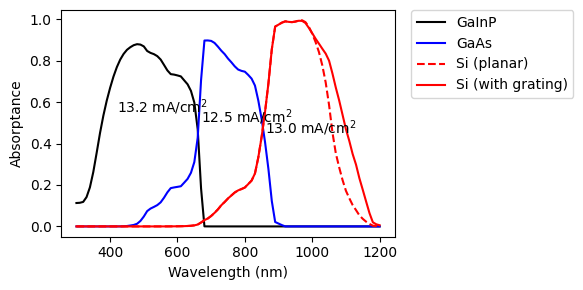

In [27]:
Si_A_total = np.zeros(len(wl))
Si_A_total[tmm_result['T'] > 1e-4] = RAT['A_bulk'][0]
Si_A_total[tmm_result['T'] <= 1e-4] = Si_A[tmm_result['T'] <= 1e-4]

Jmax_Si_grating = q*np.trapz(Si_A_total*AM15G.spectrum()[1], x=wl)/10

plt.figure(figsize=(6,3))
plt.plot(wl * 1e9, GaInP_A, "-k", label="GaInP")
plt.plot(wl * 1e9, GaAs_A, "-b", label="GaAs")
plt.plot(wl * 1e9, Si_A, "--r", label="Si (planar)")
plt.plot(wl * 1e9, Si_A_total, '-r', label="Si (with grating)")
plt.text(420, 0.55, r"{:.1f} mA/cm$^2$".format(Jmax_GaInP))
plt.text(670, 0.50, r"{:.1f} mA/cm$^2$".format(Jmax_GaAs))
plt.text(860, 0.45, r"{:.1f} mA/cm$^2$".format(Jmax_Si_grating))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorptance")

plt.tight_layout()
plt.show()

## Questions

- Why does the grating only affect the absorption in Si at long wavelengths?
- What is the reason for using the angular redistribution matrix method, rather
  than defining an RCWA-only structure (`rcwa_structure`)?
- We did not explicitly set the Si to be incoherent in the second calculation (with the diffraction) grating, but we do not see any sharp interference fringes, indicating that interference in the Si was actually disregarded. Why?